In [1]:
import numpy as np 
import cv2
import glob
import matplotlib.pyplot as plt

In [2]:
groundtruth_matings = [
    ("P_9_E_2","P_6_E_1"),
    ("P_9_E_0","P_7_E_1"),
    ("P_0_E_3","P_1_E_0"),
    ("P_2_E_0","P_1_E_1"),
    ("P_0_E_1","P_8_E_2")
]

## Loading Images

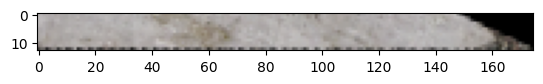

In [3]:
data_dir = "../data/poc_10_pictorial_compatibility/"
edge2original_image = {}
edge2extrpolated_image = {}

for file in glob.glob(data_dir+"*.png"):
    file_name = file.split("\\")[-1]
    splitted = file_name.split("_")
    splitted_dash = splitted[0].split("-")
    edge = "_".join(splitted_dash[4:])

    if "ext" in splitted[1]:
        edge2extrpolated_image[edge] = cv2.imread(file)
    elif "original" in splitted[1]:
        edge2original_image[edge] = cv2.imread(file)


plt.imshow(edge2original_image["P_9_E_2"])

## Preprocessing

In [4]:

'''
    Normalizing
'''
channels_sum = np.zeros((3,1))
pixels_count = 0

for edge in edge2original_image.keys():
    img = edge2original_image[edge]
    channels_sum += np.sum(img,axis=(0,1)).reshape(3,1) 
    pixels_count+= img.shape[0]*img.shape[1]

channels_mean = (channels_sum/pixels_count).astype(np.double).T

for edge in edge2original_image.keys():
    edge2original_image[edge] = edge2original_image[edge].astype(np.double) - channels_mean
    edge2extrpolated_image[edge] = edge2extrpolated_image[edge].astype(np.double) - channels_mean
    
'''
    flipping
'''
for edge in edge2original_image.keys():
    edge2original_image[edge] = np.flip(edge2original_image[edge],axis=(0,1))

'''
    Cropping
'''
crop_size = 5 
for edge in edge2original_image.keys():
    edge2original_image[edge] = edge2original_image[edge][:crop_size]
    edge2extrpolated_image[edge] = edge2extrpolated_image[edge][:crop_size]

## Comparing

In [19]:
def compatibility_v1(img1,img2):

    assert img1.shape[0] == img2.shape[0]

    feature_map_img = img2
    kernel_img = img1

    if img1.shape[1] > img2.shape[1]:
        feature_map_img = img1
        kernel_img = img2

    non_zero_kernel = np.argwhere(np.any(kernel_img!=[0,0,0],axis=2))
    products = []

    start_col = 0
    end_col = start_col + kernel_img.shape[1]
    receptive_field = feature_map_img[:,start_col:end_col]

    non_zero_receptive_field = np.argwhere(np.any(receptive_field!=[0,0,0],axis=2))
    
    non_zero_mutual = [ind for ind in non_zero_receptive_field if ind in non_zero_kernel]

    receptive_field_norm = np.linalg.norm(receptive_field[non_zero_mutual])
    kernel_norm = np.linalg.norm(kernel_img[non_zero_mutual])

    products.append(np.sum(kernel_img[non_zero_mutual]*receptive_field[non_zero_mutual])/receptive_field_norm/kernel_norm)

    return max(products)

In [21]:
for edge1,edge2 in groundtruth_matings:
    print(f"Comparing {edge1} <===> {edge2}")
    score_1 = compatibility_v1(edge2original_image[edge1],
                                edge2extrpolated_image[edge2])
    print(f"\tscore of {edge1} (original) and {edge2} (extrapolated) is {score_1}")

    score_2 = compatibility_v1(edge2original_image[edge2],
                                edge2extrpolated_image[edge1])
    print(f"\tscore of {edge2} (original) and {edge1} (extrapolated) is {score_2}")
    

Comparing P_9_E_2 <===> P_6_E_1


IndexError: index 5 is out of bounds for axis 0 with size 5

In [8]:
def plot_two_edges(edge1,edge2):

    fig, axs = plt.subplots(2,2)

    axs[0,0].imshow(edge2original_image[edge1])
    axs[0,0].set_title(f"{edge1} original")
    axs[0,1].imshow(edge2extrpolated_image[edge1])
    axs[0,0].set_title(f"{edge1} extrapolated")
    axs[1,0].imshow(edge2original_image[edge2])
    axs[0,0].set_title(f"{edge2} original")
    axs[1,1].imshow(edge2extrpolated_image[edge2])
    axs[0,0].set_title(f"{edge2} extrapolated")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


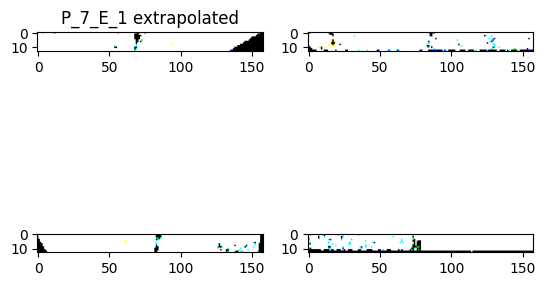

In [9]:
plot_two_edges("P_9_E_0","P_7_E_1")